In [1]:
# Jypyter notebook specific
%matplotlib inline
from IPython.display import display, HTML

# Standard imports
import logging
import glob
import os

# Dependecy imports
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

import keras.backend.tensorflow_backend as K

K_CONFIG = K.tf.ConfigProto()
K_CONFIG.allow_soft_placement = True
K_CONFIG.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=K_CONFIG))

Using TensorFlow backend.


# Load log file

In [2]:
im_paths = glob.glob('traffic_light_images/**/*.png')
im_paths += glob.glob('traffic_light_images/**/*.jpg')

labels = []

red = 0
green = 0

for path in im_paths:
    label = int(os.path.dirname(path).split('/')[-1])
    
    if label == 0 or label == 1:
        labels.append(0)
        red += 1
    elif label == 2:
        labels.append(1)
        green += 1

print('red', red, 'green', green)
print(len(im_paths))
print(len(labels))

red 1081 green 1130
2211
2211


# Load images

In [3]:
import cv2
import numpy as np

In [4]:
width = 400
height = 300

images = []

for path in im_paths:

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_res = cv2.resize(img, (width, height))
    
    images.append(img_res)

In [5]:
images = np.asarray(images)
print(images.shape, images.dtype)

labels = np.asarray(labels)
print(labels.shape, labels.dtype)

(2211, 300, 400, 3) uint8
(2211,) int64


In [6]:
images, labels = shuffle(images, labels)

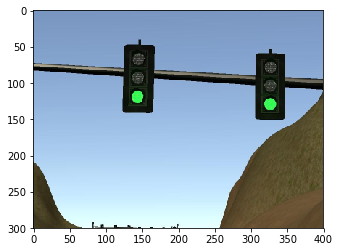

1


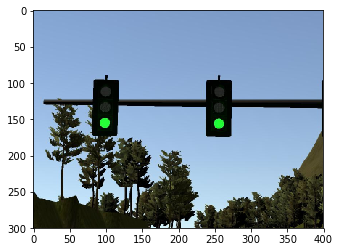

1


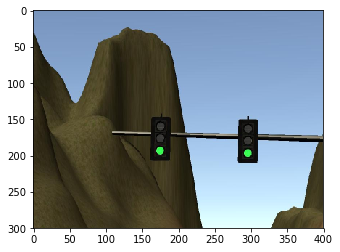

1


In [7]:
plt.imshow(images[800])
plt.show()
print(labels[800])
plt.imshow(images[500])
plt.show()
print(labels[500])
plt.imshow(images[300])
plt.show()
print(labels[300])

# Train model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
from keras.utils.data_utils import Sequence

In [9]:
activation = 'relu'
dropout = 1

def model(dshape):
    """Create keras model.

    Based on : https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
    """
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))

    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [10]:
keras_model = model((height, width, 3))  # creates model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 300, 400, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 198, 24)      1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 97, 36)        21636     
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 97, 36)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 47, 48)        43248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 34, 47, 48)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 45, 64)        27712     
__________

In [11]:
keras_model.fit(images, labels, epochs=10, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 1768 samples, validate on 443 samples
Epoch 1/10
1768/1768 [==============================] - 9s - loss: 0.7117 - acc: 0.5023 - val_loss: 0.6929 - val_acc: 0.5418
Epoch 2/10
1768/1768 [==============================] - 7s - loss: 0.6785 - acc: 0.5045 - val_loss: 0.5450 - val_acc: 0.9413
Epoch 3/10
1768/1768 [==============================] - 7s - loss: 0.4029 - acc: 0.9282 - val_loss: 0.3138 - val_acc: 0.9887
Epoch 4/10
1768/1768 [==============================] - 7s - loss: 0.2914 - acc: 0.9847 - val_loss: 0.2402 - val_acc: 0.9436
Epoch 5/10
1768/1768 [==============================] - 7s - loss: 0.1489 - acc: 0.9745 - val_loss: 0.0633 - val_acc: 0.9887
Epoch 6/10
1768/1768 [==============================] - 7s - loss: 0.0853 - acc: 0.9904 - val_loss: 0.0466 - val_acc: 0.9910
Epoch 7/10
1768/1768 [==============================] - 7s - loss: 0.2317 - acc: 0.9587 - val_loss: 0.0876 - val_acc: 0.9774
Epoch 8/10
1768/1768 [==============================] - 7s - loss: 0.0936 - ac

In [12]:
def save_keras_model(save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [13]:
save_keras_model(keras_model, 'keras')

# Test model

In [14]:
from keras.models import model_from_json

In [15]:
model_path = 'kerasmodel'

In [16]:
inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [17]:
print(round(inf_model.predict(np.expand_dims(images[800], 0))[0, 0]))
print(round(inf_model.predict(np.expand_dims(images[500], 0))[0, 0]))
print(round(inf_model.predict(np.expand_dims(images[300], 0))[0, 0]))

1.0
1.0
1.0
